In [50]:
# Daniel Bandala @ apr 2022
import os
import numpy as np
from skvideo.io import vread,vwrite
from IPython.display import Video
import matplotlib.pyplot as plt
from matplotlib import animation
import PIL
import tensorflow as tf
from PIL import Image,ImageFont,ImageDraw
from IPython.display import HTML
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

# VGG16 Network
It is a Convolutional Neural Network (CNN) model proposed by Karen Simonyan and Andrew Zisserman at the University of Oxford. The idea of the model was proposed in 2013, but the actual model was submitted during the ILSVRC ImageNet Challenge in 2014. The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) was an annual competition that evaluated algorithms for image classification (and object detection) at a large scale. They did well in the challenge but couldn’t win.

VGG16 proved to be a significant milestone in the quest of mankind to make computers “see” the world. A lot of effort has been put into improving this ability under the discipline of Computer Vision (CV) for a number of decades. VGG16 is one of the significant innovations that paved the way for several innovations that followed in this field.

<img src="https://lh5.googleusercontent.com/yiz4POx7TGD21dQ7QvfI7fW5l4DNdvfR-EJsMmvxrKdeM9KNqz2TNWnOD7zmtIDXunVbx6zdXzQrL_6KD03QdIRauzwlaOidT9WIQA1O1NQ-M8_nqIes3hf_6SFVCQJQ2rKPWIkWearCBG5f1g=s0">

The input to any of the network configurations is considered to be a fixed size 224 x 224 image with three channels – R, G, and B. The only pre-processing done is normalizing the RGB values for every pixel. This is achieved by subtracting the mean value from every pixel. Image is passed through the first stack of 2 convolution layers of the very small receptive size of 3 x 3, followed by ReLU activations. Each of these two layers contains 64 filters. The convolution stride is fixed at 1 pixel, and the padding is 1 pixel. This configuration preserves the spatial resolution, and the size of the output activation map is the same as the input image dimensions. The activation maps are then passed through spatial max pooling over a 2 x 2-pixel window, with a stride of 2 pixels. This halves the size of the activations. Thus the size of the activations at the end of the first stack is 112 x 112 x 64. 

In [2]:
# load model
model = VGG16(weights='vgg16_weights.h5')

2022-04-24 14:37:30.860388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 14:37:30.890303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 14:37:30.890500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 14:37:30.891279: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Transfer learning
Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch. The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data. The idea is to re-use a pre-trained model, in this case the VGG16 model, which consists of several convolutional layers (actually blocks of multiple convolutional layers), followed by some fully-connected / dense layers and then a softmax output layer for the classification. The dense layers are responsible for combining features from the convolutional layers and this helps in the final classification. So when the VGG16 model is used on another dataset we may have to replace all the dense layers. In this case we add another dense-layer and a dropout-layer to avoid overfitting. The difference between Transfer Learning and Fine-Tuning is that in Transfer Learning we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model. In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

### Helper Functions

In [3]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [4]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)
    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(12,12))

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [6]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [7]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict(generator_test, steps=steps_test)
    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)
    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [8]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    return np.asarray(images,dtype=object)

In [9]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16,8))
    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    # Plot it for the test-set
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    # Plot title and legend
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid()
    # plot loss function
    plt.figure(figsize=(16,8))
    plt.plot(loss, '-o', color='b', label='Training Loss')
    # Plot it for the test-set
    plt.plot(val_loss, '-o', color='r', label='Test Loss')
    # Plot title and legend.
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid()
    # Ensure the plot shows correctly.
    plt.show()

In [10]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)
    # Plot the image.
    plt.imshow(img_resized)
    plt.show()
    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)
    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]
    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

In [11]:
def print_layer_trainable(in_model):
    for layer in in_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

### Modified model
The lower layers of a Convolutional Neural Network can recognize many different shapes or features in an image. It is the last few fully-connected layers that combine these featuers into classification of a whole image. So we can try and re-route the output of the last convolutional layer of the VGG16 model to a new fully-connected neural network that we create for doing classification on the human detection problem. First we need to know the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3.

In [12]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [14]:
# last convolutional layer is called 'block5_pool' so we use Keras to get a reference to that layer.
transfer_layer = model.get_layer('block5_pool')

In [15]:
transfer_layer.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

Using the Keras API it is very simple to create a new model. First we take the part of the VGG16 model from its input-layer to the output of the transfer-layer. We may call this the convolutional model, because it consists of all the convolutional layers from the VGG16 model.

In [16]:
conv_model = Model(inputs=model.input,outputs=transfer_layer.output)

The difference between Transfer Learning and Fine-Tuning is that in Transfer Learning we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model. In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

<img style="width:60%" alt="Flowchart of Transfer Learning &amp; Fine-Tuning" src="//github.com/Hvass-Labs/TensorFlow-Tutorials/raw/d5f33973570fe6ef9c78c8a38c7449a932c81010//images/10_transfer_learning_flowchart.png">

In [17]:
# build new model
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual binary classification in human detection
new_model.add(Dense(2,activation='softmax'))

In Transfer Learning we are initially only interested in reusing the pre-trained VGG16 model as it is, so we will disable training for all its layers.

In [18]:
conv_model.trainable = False

In [19]:
print_layer_trainable(conv_model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [20]:
print_layer_trainable(new_model)

False:	model
True:	flatten
True:	dense
True:	dropout
True:	dense_1


In [21]:
# once we have changed whether the model's layers are trainable, we need to compile the model for the changes to take effect
epochs = 20
optimizer = Adam(learning_rate=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Load fine tunning dataset for human detection
Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity.
We have a small training-set so it helps to artificially inflate its size by making various transformations to the images. We use a built-in data-generator that can make these random transformations. This is also called an augmented dataset.

In [22]:
datagen_train = ImageDataGenerator(
      #rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

We also need a data-generator for the test-set, but this should not do any transformations to the images because we want to know the exact classification accuracy on those specific images. So we just rescale the pixel-values so they are between 0.0 and 1.0 because this is expected by the VGG16 model.

In [23]:
datagen_test = ImageDataGenerator()
    #rescale=1./255)

Now we create the actual data-generator that will read files from disk, resize the images and return a random batch.

It is somewhat awkward that the construction of the data-generator is split into these two steps, but it is probably because there are different kinds of data-generators available for different data-types (images, text, etc.) and sources (memory or disk).

In [24]:
batch_size = 20
train_dir = "human_detection_dataset/train"
test_dir = "human_detection_dataset/valid"
save_to_dir="human_detection_dataset/augmented_images"

In [25]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=None)

Found 861 images belonging to 2 classes.


In [26]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 60 images belonging to 2 classes.


In [27]:
steps_test = generator_test.n / batch_size
steps_test

3.0

In [28]:
# This is another slightly awkward aspect of the Keras API which could perhaps be improved
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [29]:
# Get the file-paths for all the images in the training- and test-sets
cls_train = generator_train.classes
cls_test = generator_test.classes

In [30]:
# Get the class-names for the dataset
class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
class_names

['human', 'no_human']

### Plot a few images to see if data is correct

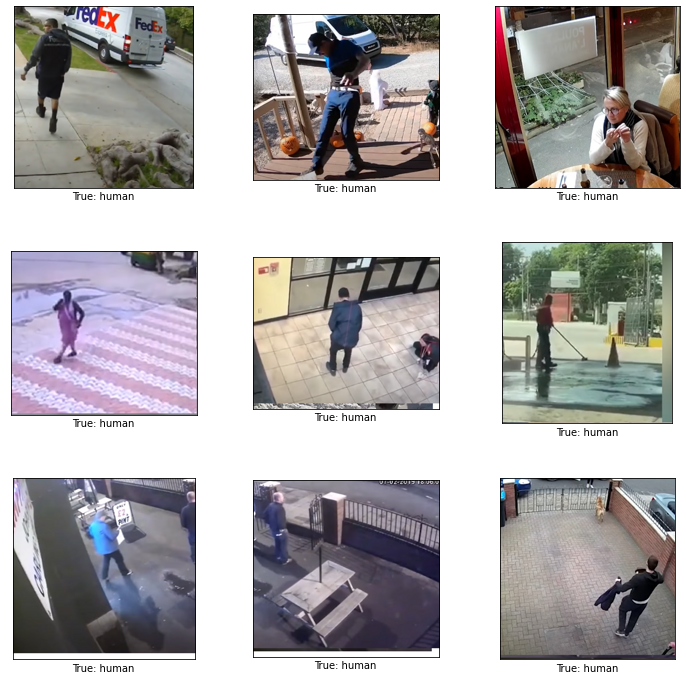

In [31]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])
# Get the true classes for those images.
cls_true = cls_train[0:9]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Classes weight

In [32]:
class_weight = compute_class_weight(class_weight='balanced',classes=np.unique(cls_train),y=cls_train)

In [33]:
print(class_names," => ",class_weight)

['human', 'no_human']  =>  [0.81379962 1.29668675]


In [34]:
# make dictionary
class_weight = dict(enumerate(class_weight))

## Train new model

In [35]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 40,407,874
Trainable params: 25,693,186
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        class_weight=class_weight,
                        validation_data=generator_test,
                        validation_steps=steps_test,
                        verbose=True)

Epoch 1/20


2022-04-24 14:37:48.600981: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400
2022-04-24 14:37:49.129438: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-24 14:37:49.522900: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-24 14:37:49.522976: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-24 14:37:49.523048: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.6

44/44 [==============================] - 15s 233ms/step - loss: 8.0804 - categorical_accuracy: 0.5772 - val_loss: 4.5077 - val_categorical_accuracy: 0.5667
Epoch 2/20
44/44 [==============================] - 12s 270ms/step - loss: 6.0828 - categorical_accuracy: 0.6318 - val_loss: 3.6318 - val_categorical_accuracy: 0.6833
Epoch 3/20
44/44 [==============================] - 12s 272ms/step - loss: 5.6063 - categorical_accuracy: 0.6922 - val_loss: 3.7114 - val_categorical_accuracy: 0.6500
Epoch 4/20
44/44 [==============================] - 12s 263ms/step - loss: 6.0394 - categorical_accuracy: 0.6678 - val_loss: 2.8504 - val_categorical_accuracy: 0.7500
Epoch 5/20
44/44 [==============================] - 12s 266ms/step - loss: 5.4435 - categorical_accuracy: 0.6736 - val_loss: 2.7438 - val_categorical_accuracy: 0.7500
Epoch 6/20
44/44 [==============================] - 12s 271ms/step - loss: 4.2385 - categorical_accuracy: 0.7305 - val_loss: 2.7750 - val_categorical_accuracy: 0.7500
Epoch 7/2

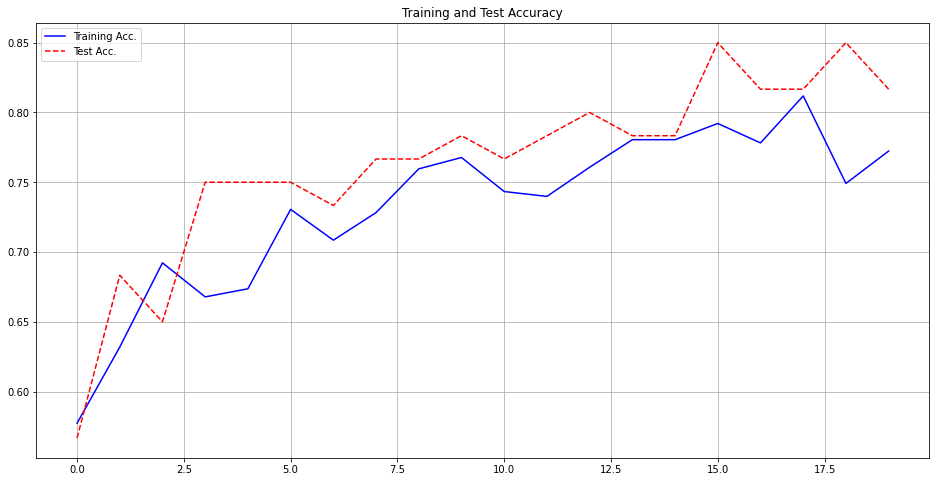

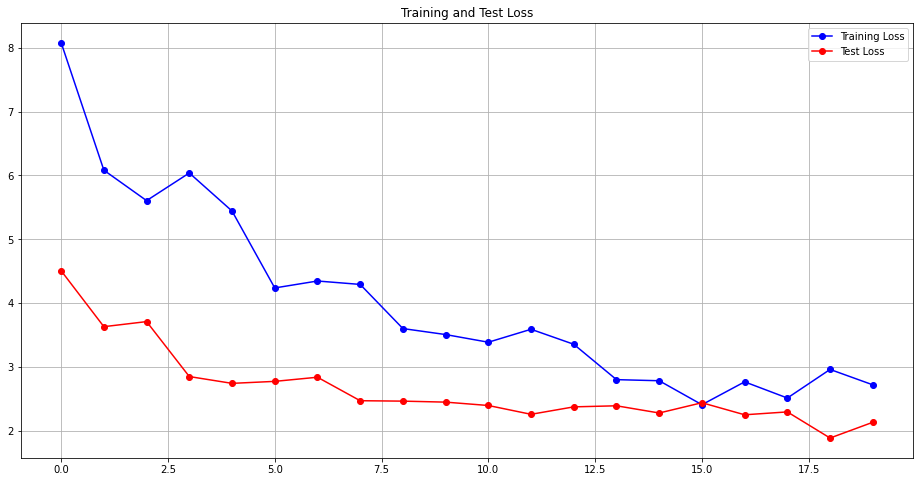

In [37]:
plot_training_history(history)

In [38]:
result = new_model.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

3/3 [==============================] - 1s 194ms/step - loss: 2.1342 - categorical_accuracy: 0.8167
Test-set classification accuracy: 81.67%


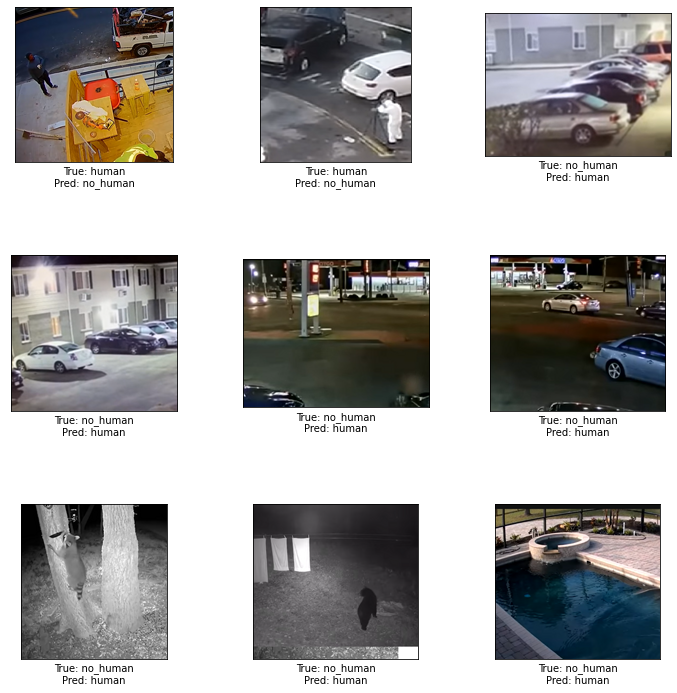

Confusion matrix:
[[28  2]
 [ 9 21]]
(0) human
(1) no_human


In [39]:
example_errors()

# Fine-Tuning
In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original VGG16 model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the VGG16 model that may either distort its weights or cause overfitting to the new dataset. But once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the VGG16 model as well. We call this Fine-Tuning.

In [40]:
# enable train parameters from the last two convolutional layers whose names contain 'block5'
conv_model.trainable = True
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name)
    # Set the layer's bool.
    layer.trainable = trainable

In [41]:
print_layer_trainable(conv_model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [42]:
print_layer_trainable(new_model)

True:	model
True:	flatten
True:	dense
True:	dropout
True:	dense_1


In [43]:
# a lower learning-rate for the fine-tuning so the weights of the original VGG16 model only get changed slowly.
optimizer_fine = Adam(learning_rate=1e-8)

In [44]:
# compile new model
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [45]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        class_weight=class_weight,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/20
44/44 [==============================] - 13s 266ms/step - loss: 2.7954 - categorical_accuracy: 0.8037 - val_loss: 2.1290 - val_categorical_accuracy: 0.8167
Epoch 2/20
44/44 [==============================] - 12s 258ms/step - loss: 2.7549 - categorical_accuracy: 0.8060 - val_loss: 2.1207 - val_categorical_accuracy: 0.8167
Epoch 3/20
44/44 [==============================] - 12s 262ms/step - loss: 2.3098 - categorical_accuracy: 0.8095 - val_loss: 2.1154 - val_categorical_accuracy: 0.8167
Epoch 4/20
44/44 [==============================] - 12s 263ms/step - loss: 2.8183 - categorical_accuracy: 0.7921 - val_loss: 2.1103 - val_categorical_accuracy: 0.8167
Epoch 5/20
44/44 [==============================] - 12s 260ms/step - loss: 2.3039 - categorical_accuracy: 0.8153 - val_loss: 2.1033 - val_categorical_accuracy: 0.8167
Epoch 6/20
44/44 [==============================] - 12s 265ms/step - loss: 2.8476 - categorical_accuracy: 0.7909 - val_loss: 2.0958 - val_categorical_accuracy: 0.816

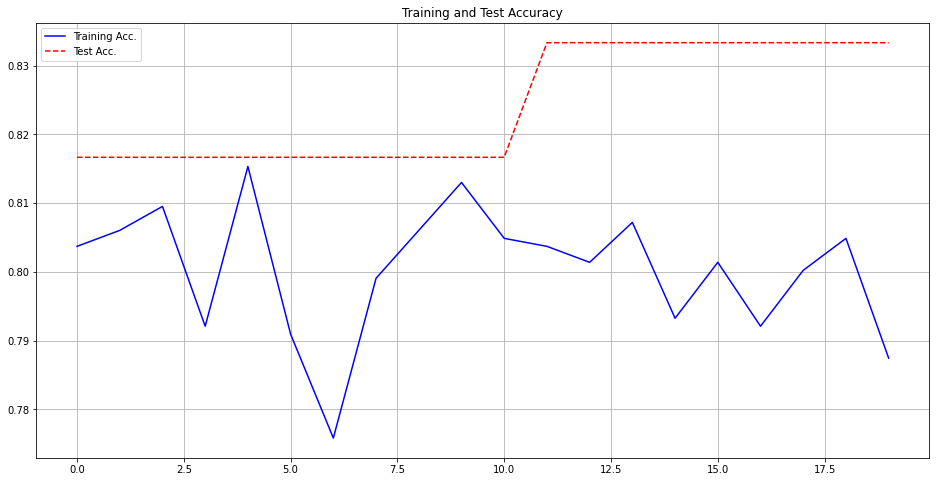

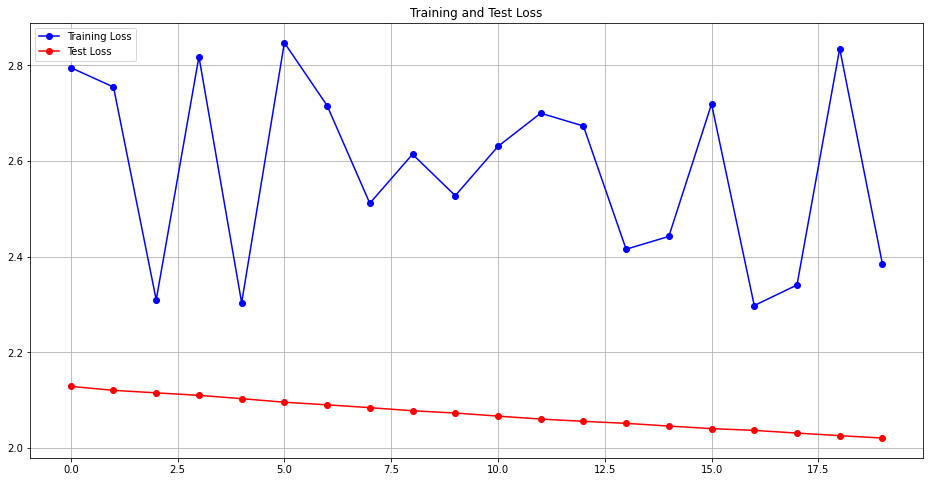

In [46]:
# show trainning and validation graphs
plot_training_history(history)

In [47]:
result = new_model.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

3/3 [==============================] - 1s 195ms/step - loss: 2.0210 - categorical_accuracy: 0.8333
Test-set classification accuracy: 83.33%


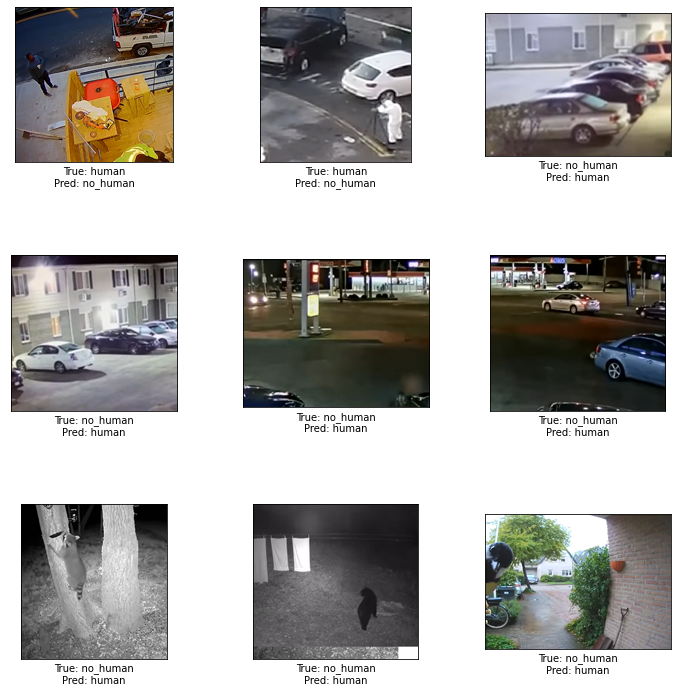

Confusion matrix:
[[28  2]
 [ 8 22]]
(0) human
(1) no_human


In [48]:
example_errors()

### Save model weights

In [49]:
# save model
new_model.save('hd_vgg.h5')

### Load model weights

In [51]:
hd_model = load_model('hd_vgg.h5')

# Home automation
Home automation or domotics is building automation for a home, called a smart home or smart house. A home automation system will monitor and/or control home attributes such as lighting, climate, entertainment systems, and appliances. It may also include home security such as access control and alarm systems. When connected with the Internet, home devices are an important constituent of the Internet of Things ("IoT"). A home automation system typically connects controlled devices to a central smart home hub (sometimes called a "gateway"). The user interface for control of the system uses either wall-mounted terminals, tablet or desktop computers, a mobile phone application, or a Web interface that may also be accessible off-site through the Internet.

Home automation is prevalent in a variety of different realms, including:
- Heating, ventilation and air conditioning (HVAC): it is possible to have remote control of all home energy monitors over the internet incorporating a simple and friendly user interface.
- Lighting control system: a "smart" network that incorporates communication between various lighting system inputs and outputs, using one or more central computing devices.
- Occupancy-aware control system: it is possible to sense the occupancy of the home using smart meters and environmental sensors like CO2 sensors, which can be integrated into the building automation system to trigger automatic responses for energy efficiency and building comfort applications.
- Appliance control and integration with the smart grid and a smart meter, taking advantage, for instance, of high solar panel output in the middle of the day to run washing machines.
- Home robots and security: a household security system integrated with a home automation system can provide additional services such as remote surveillance of security cameras over the Internet, or access control and central locking of all perimeter doors and windows.
- Leak detection, smoke and CO detectors
- Laundry-folding machine, self-making bed
- Indoor positioning systems (IPS).
- Home automation for the elderly and disabled.

In [52]:
# resize and normilize images
def preprocess(img, shape=None):
    if shape is not None:
        y,x,c = img.shape
        starty = y//2-(shape[0]//2)
        startx = x//2-(shape[1]//2)
        img = img[starty:starty+shape[0],startx:startx+shape[1],:]
        #img = resize(img, shape)
    if np.max(img)<=1:
        img = (img*255).astype(np.uint8)
    return np.expand_dims(img,axis=0)

In [53]:
# show original video
video_filename = 'vcr-videos.mp4'
Video(video_filename)

In [75]:
# read frames video
videodata = vread(video_filename)
print("Frames readed: ",videodata.shape[0])

Frames readed:  1320


In [76]:
# make predictions on each frame
text_font = ImageFont.truetype('/usr/share/fonts/truetype/open-sans/OpenSans-Bold.ttf',size=20)
for i in range(videodata.shape[0]):
    img_frame = videodata[i]
    # resize and expand dimensions of image
    pre = preprocess(img_frame,(224,224))
    # prepare image
    net_input = preprocess_vgg(pre)
    # make predictions with vgg model
    prediction = model.predict(net_input)
    # make predictions with vgg model for human detection
    hd_prediction = hd_model.predict(net_input)[0]
    # add predictions to frame
    text_predictions = "VGG-Net Predictions:\n"
    text_predictions += "HUMAN\n" if hd_prediction[0]>0.9 else "NO HUMAN\n"
    for p in decode_predictions(prediction, top=6)[0]:
        if p[2]*100>=10:
            text_predictions += f'{p[1]} -> {p[2]*100:.1f}% \n'
    # draw predictions on frame
    img = Image.fromarray(img_frame.astype('uint8'), 'RGB')
    edit_image = ImageDraw.Draw(img)
    edit_image.text((20,20),text_predictions,("red"),font=text_font)
    # return pillow image to numpy array
    videodata[i] = np.array(img)

In [77]:
# save processed video
vwrite("processed-"+video_filename,videodata)

In [78]:
# show results
Video("processed-"+video_filename)

In [79]:
%matplotlib inline
# np array with shape (frames, height, width, channels)
fig = plt.figure()
im = plt.imshow(videodata[0,:,:,:])
plt.close() # this is required to not display the generated image
def init():
    im.set_data(videodata[0,:,:,:])
def animate(i):
    im.set_data(videodata[i,:,:,:])
    return im
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=videodata.shape[0], interval=50)
# render video
HTML(anim.to_html5_video())